In [194]:
from __future__ import division, absolute_import

import os
import sys
import random

#don't use GPUs
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import h5py
import pickle
import numpy as np
import keras
import pandas as pd
import random
import logomaker

from glob import glob
from keras.models import load_model
from keras import models
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

#root
absPath = '/home/angela/padding_EBI/'
sys.path.insert(0, absPath)

from src.Target import Target

np.random.seed(1)
random.seed(1)
%matplotlib inline

In [195]:
def search_model (folder, fold, task, padding):
    model_path = "".join((absPath, "data/checkpoint/", folder, task, list_paddings[2], "/", "1", "/"))
    model_file = glob(os.path.join(model_path, "weights-*.hdf5"))[0]
    return model_file

def random_prot_idx(folder, task):
    if task == "task1":
        file_idcs = os.path.join(absPath, 'data/', folder, 'idcs_split.pickle')
    else:
        file_idcs = os.path.join(absPath, 'data/', folder, 'idcs_data_enz.pickle')
    with open(file_idcs, "rb") as input_file:
        splitting_sets = pickle.load(input_file)[0]
    i_train, i_val, i_test = splitting_sets
    len_test = len(i_test)
    rnd_index = random.randint(0, len_test-1)
    protein_index = i_test[rnd_index]
    return protein_index

def load_prot(folder, protein_index, padding, labels_label, newshape):
    data_path = os.path.join(absPath, "data/", folder, "data.h5")
    f1 = h5py.File(data_path, 'r')
    prot = f1[padding][protein_index]
    label_prot = f1[labels_label][protein_index]
    instarget = Target('AAAAAA')
    aa_to_int = instarget.predefining_dict()
    seq_onehot = instarget.int_to_onehot(list(prot), len(aa_to_int))
    seq_reshaped = np.reshape(seq_onehot, newshape=newshape)
    return seq_reshaped, label_prot

def obtain_activations(model_path, n_layer, seq_reshaped):
    model = load_model(model_path)
    layer_output = model.layers[n_layer].output
    activation_model = models.Model(inputs=model.input, outputs=layer_output) 
    activations = activation_model.predict(seq_reshaped, batch_size=1)
    shape_act = activations.shape
    activations_reshaped = np.reshape(activations, newshape=(shape_act[2], shape_act[1]))
    #print(activations_reshaped.shape)
    return activations_reshaped

def activations_to_df(activations, padding, fold):
    activations_df = pd.DataFrame(activations)
    activations_df["padding"] = padding
    activations_df["order"] = list(range(0,activations.shape[0]))
    activations_df["fold"] = fold
    #label_prot_noonehot = np.argmax(label_prot, -1)
    #activations_df["label"] = label_prot_noonehot
    return activations_df
    
#function to select proteins of the test set with an specific enzimatic label
def find_prot_labeled(folder, enz_label, quant=2):
    data_path = os.path.join(absPath, "data/", folder, "data.h5")
    f1 = h5py.File(data_path, 'r')
    indices_enzymes = []
    while len(indices_enzymes)<quant:
        idx = random_prot_idx(folder, "task2")
        label_prot = np.argmax(f1["labels_task2"][idx]) + 1
        if label_prot == enz_label:
            indices_enzymes.append(idx)
    return indices_enzymes

def load_prot_labeled(folder, padding, newshape, enz_label, idx):
    data_path = os.path.join(absPath, "data/", folder, "data.h5")
    f1 = h5py.File(data_path, 'r')
    instarget = Target('AAAAAA')
    aa_to_int = instarget.predefining_dict()
    prot = f1[padding][idx]
    seq_onehot = instarget.int_to_onehot(list(prot), len(aa_to_int))
    seq_reshaped = np.reshape(seq_onehot, newshape=newshape)
    return seq_reshaped

In [196]:
list_paddings = ['ext_padding', 'mid_padding', 'post_padding', 'pre_padding', 
                 'rnd_padding', 'strf_padding',  "zoom_padding"]

task = 'task1/'
nfolds = 10
folder = 'EC_number/archaea/1conv/64filts_size5/'
nshape = (1, 1000, 26)
nlayer = 2

In [197]:
# Representar los 64 filtros de ext padding vs los de mid_padding?
fold = 1

In [198]:
# Defining protein to take
#data_path = os.path.join(absPath, "data/", folder, "data.h5")
#f1 = h5py.File(data_path, 'r')
idx = random_prot_idx(folder, "task1")

In [201]:
def load_prot_aminoacids(folder, protein_index, padding, labels_label):
    data_path = os.path.join(absPath, "data/", folder, "data.h5")
    f1 = h5py.File(data_path, 'r')
    prot = f1[padding][protein_index]
    instarget = Target('AAAAAA')
    seq_int = f1[padding][protein_index]
    aa_to_int = instarget.predefining_dict()
    sequence_aas = int_to_aa(seq_int, aa_to_int)
    label_prot = f1[labels_label][protein_index]
    return sequence_aas, label_prot

<Figure size 216x460.8 with 0 Axes>

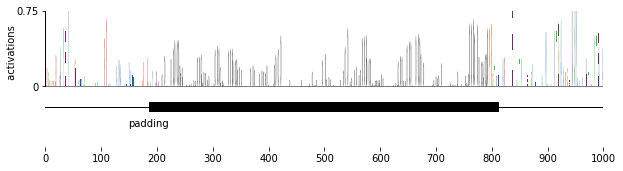

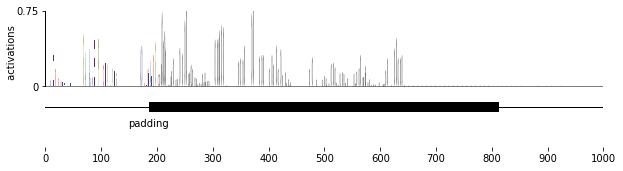

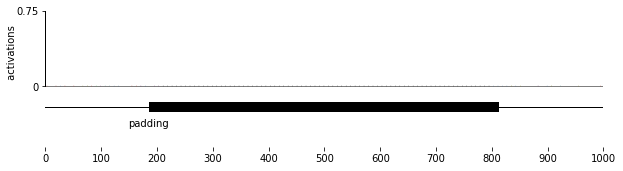

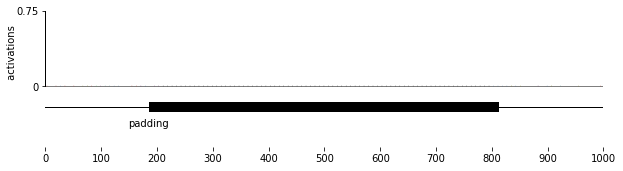

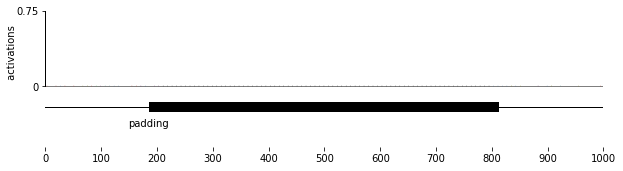

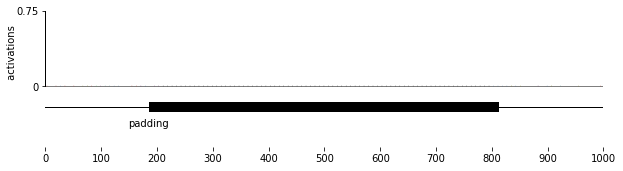

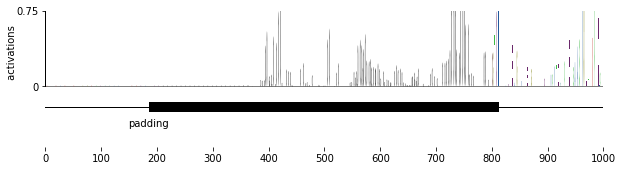

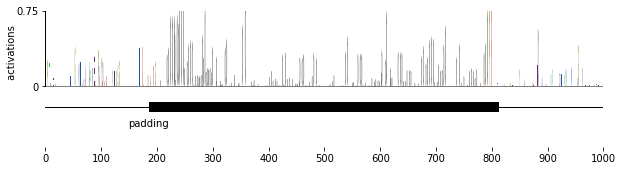

<Figure size 216x460.8 with 0 Axes>

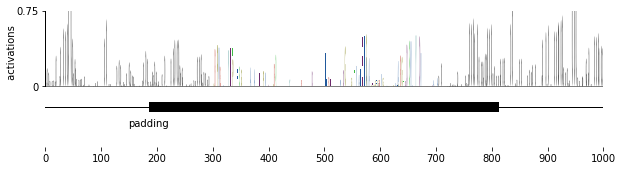

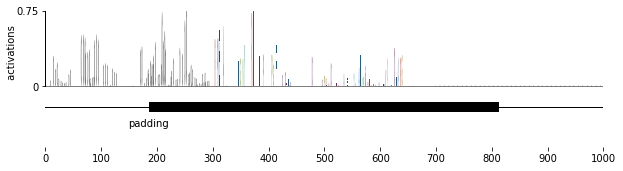

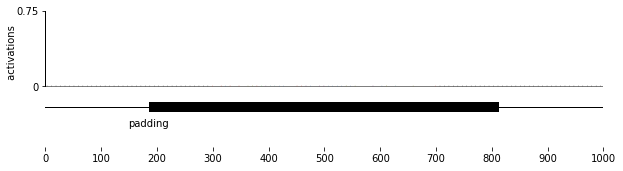

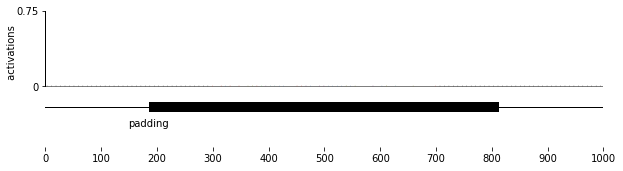

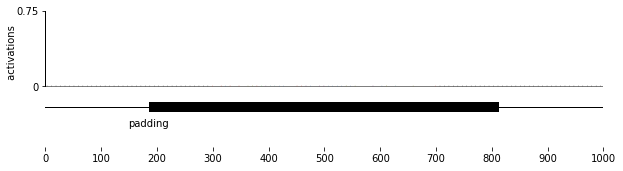

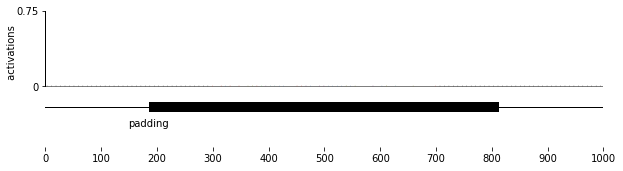

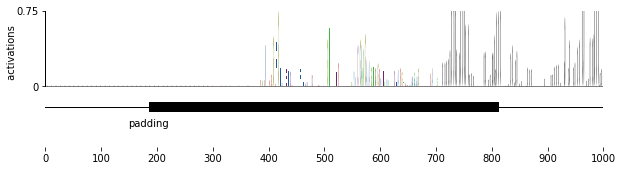

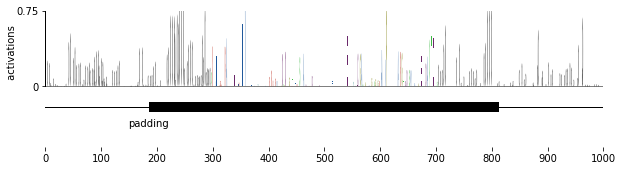

In [208]:
list_paddings = ["mid_padding", "ext_padding"]
lista_seqs = []
for padding in list_paddings:
    sequence_aas, label = load_prot_aminoacids(folder, idx, padding, "labels_task1")
    lista_seqs.append(sequence_aas)
    model_file = search_model(folder, str(fold), task, padding)
    model = load_model(model_file)
    activations = obtain_activations(model_file, nlayer, prot)
    
    df_activations = pd.Dataframe()
    for i in range(activations.shape[0]):
        
    #columns and rows
    #ncols = len(list_paddings)
    #nrows = activations.shape[0]
    
    # create figure
    #height_per_row = .8
    #width_per_col = 1.5
    #fig = plt.figure(figsize=[width_per_col * ncols, height_per_row * nrows])
    
    #for each one of the activations 
    #df_activations = 
#     for i in range(activations.shape[0]):
#         activations_i = activations[i,:]
#         activations_i_df = pd.DataFrame(activations_i, columns=["activations"])
#         activations_i_df['amino_acids'] = sequence_aas
#         activations_i_df['position'] = activations_i_df.index
        
#         pivoted_df = activations_i_df.pivot(index='position', columns='amino_acids')['activations'].reset_index()
#         pivoted_df.columns.name = None
#         pivoted_df.drop("position", axis=1, inplace=True)
#         pivoted_df.fillna(0, inplace=True)
#         indices_padding = [idx for idx, i in enumerate(sequence_aas) if i == '0']
        
#         nn_logo = logomaker.Logo(pivoted_df, color_scheme='NajafabadiEtAl2017')
#         # style using Logo methods
#         nn_logo.style_spines(visible=False)
#         nn_logo.style_spines(spines=['left'], visible=True, bounds=[0, .75])

#         # style using Axes methods
#         nn_logo.ax.set_xlim([0, 1000])
#         nn_logo.ax.set_xticks([0,100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
#         nn_logo.ax.set_ylim([-.6, .75])
#         nn_logo.ax.set_yticks([0, .75])
#         nn_logo.ax.set_yticklabels(['0', '0.75'])
#         nn_logo.ax.set_ylabel('                 activations', labelpad=-1)

#         # draw gene
#         nn_logo.ax.axhline(y, color='k', linewidth=1)
#         #nn_logo.ax.plot(xs, ys, marker='4', linewidth=0, markersize=7, color='k')
#         nn_logo.ax.plot([first_zero, last_zero],
#                 [y, y], color='k', linewidth=10, solid_capstyle='butt')

#         # annotate gene
#         #nn_logo.ax.plot(first_zero, 1.8*y, '^k', markersize=15)
#         nn_logo.ax.text(first_zero, 1.6*y,'padding', verticalalignment='top', horizontalalignment='center')

In [206]:
len(sequence_aas)

2

In [207]:
sequence_aas

(['M',
  'I',
  'Q',
  'K',
  'P',
  'R',
  'G',
  'T',
  'R',
  'D',
  'M',
  'L',
  'P',
  'D',
  'E',
  'M',
  'E',
  'R',
  'R',
  'R',
  'E',
  'I',
  'E',
  'A',
  'R',
  'M',
  'R',
  'A',
  'R',
  'A',
  'R',
  'L',
  'Y',
  'G',
  'F',
  'R',
  'E',
  'I',
  'A',
  'T',
  'P',
  'V',
  'F',
  'E',
  'E',
  'L',
  'E',
  'L',
  'F',
  'T',
  'I',
  'R',
  'S',
  'G',
  'E',
  'G',
  'I',
  'I',
  'N',
  'E',
  'M',
  'Y',
  'V',
  'F',
  'E',
  'D',
  'K',
  'G',
  'G',
  'R',
  'S',
  'L',
  'A',
  'L',
  'R',
  'P',
  'E',
  'L',
  'T',
  'A',
  'P',
  'V',
  'L',
  'R',
  'M',
  'Y',
  'V',
  'E',
  'E',
  'G',
  'R',
  'S',
  'L',
  'N',
  'K',
  'P',
  'V',
  'K',
  'W',
  'C',
  'Y',
  'F',
  'A',
  'D',
  'C',
  'F',
  'R',
  'Y',
  'E',
  'R',
  'P',
  'Q',
  'K',
  'G',
  'R',
  'Y',
  'R',
  'Q',
  'F',
  'W',
  'Q',
  'F',
  'G',
  'A',
  'E',
  'L',
  'I',
  'G',
  'A',
  'D',
  'S',
  'A',
  'M',
  'G',
  'D',
  'A',
  'E',
  'V',
  'I',
  'T',
  'L',
  'G',
  'Y',

In [106]:
activations.shape

(8, 1000)

In [202]:
#Loading both amino acid sequences

sequence_aas_ext = load_prot_aminoacids(folder, idx, "ext_padding", "labels_task1")

In [67]:
model_file = search_model(folder, str(fold), task, model_type)
model = load_model(model_file)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1000, 26)          0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1000, 26)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1000, 64)          8384      
_________________________________________________________________
dense_9 (Dense)              (None, 1000, 314)         20410     
_________________________________________________________________
dropout_10 (Dropout)         (None, 1000, 314)         0         
_________________________________________________________________
dense_10 (Dense)             (None, 1000, 77)          24255     
_________________________________________________________________
dropout_11 (Dropout)         (None, 1000, 77)          0         
__________

In [99]:
seq_int = f1["mid_padding"][idx]
instarget = Target('AAAAAA')
aa_to_int = instarget.predefining_dict()
sequence_aas = int_to_aa(seq_int, aa_to_int)

In [66]:
model_type = "mid_padding"
fold = 1

In [102]:
nlayer = 2

In [103]:
prot, label = load_prot(folder, idx, model_type, "labels_task2", nshape)

In [104]:
activations = obtain_activations(model_file, nlayer, prot)

In [105]:
activations

array([[ 0.01022628,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.11225662,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.31081998,  0.        ],
       [ 0.        ,  0.01957784,  0.        , ...,  0.        ,
         0.0969834 ,  0.        ]], dtype=float32)

In [107]:
#saving one of the activations
activations_first = activations[0,:]

In [115]:
activations_1_df = pd.DataFrame(activations_first, columns=["activations"])

In [116]:
activations_1_df['amino_acids'] = sequence_aas

In [117]:
activations_1_df['position'] = activations_1_df.index

In [118]:
activations_1_df.shape

(1000, 3)

In [119]:
activations_1_df

,activations,amino_acids,position
0,0.010226,M,0
1,0.000000,S,1
2,0.000000,I,2
3,0.002002,D,3
4,0.011186,D,4
5,0.000000,K,5
6,0.000000,V,6
7,0.009755,R,7
8,0.018309,A,8
9,0.000000,I,9


In [131]:
pivoted_df = activations_1_df.pivot(index='position', columns='amino_acids')['activations'].reset_index()
pivoted_df.columns.name = None
pivoted_df.drop("position", axis=1, inplace=True)

In [132]:
pivoted_df.fillna(0, inplace=True)

In [133]:
pivoted_df.head()

,0,A,C,D,E,F,G,H,I,K,...,M,N,P,Q,R,S,T,V,W,Y
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.010226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.002002,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.011186,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [134]:
pivoted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
0    1000 non-null float32
A    1000 non-null float32
C    1000 non-null float32
D    1000 non-null float32
E    1000 non-null float32
F    1000 non-null float32
G    1000 non-null float32
H    1000 non-null float32
I    1000 non-null float32
K    1000 non-null float32
L    1000 non-null float32
M    1000 non-null float32
N    1000 non-null float32
P    1000 non-null float32
Q    1000 non-null float32
R    1000 non-null float32
S    1000 non-null float32
T    1000 non-null float32
V    1000 non-null float32
W    1000 non-null float32
Y    1000 non-null float32
dtypes: float32(21)
memory usage: 82.1 KB


In [149]:
#buscar de donde a donde va el padding para representarlo
indices_padding = [idx for idx, i in enumerate(sequence_aas) if i == '0']
indices_padding


[185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 240,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 252,
 253,
 254,
 255,
 256,
 257,
 258,
 259,
 260,
 261,
 262,
 263,
 264,
 265,
 266,
 267,
 268,
 269,
 270,
 271,
 272,
 273,
 274,
 275,
 276,
 277,
 278,
 279,
 280,
 281,
 282,
 283,
 284,
 285,
 286,
 287,
 288,
 289,
 290,
 291,
 292,
 293,
 294,
 295,
 296,
 297,
 298,
 299,
 300,
 301,
 302,
 303,
 304,
 305,
 306,
 307,
 308,
 309,
 310,
 311,
 312,
 313,
 314,
 315,
 316,
 317,
 318,
 319,
 320,
 321,
 322,
 323,
 324,
 325,
 326,
 327,
 328,
 329,
 330,
 331,
 332,
 333,
 334,
 335,
 336,
 337,
 338,
 339,
 340,
 341,
 342,
 343,
 344,
 345,
 346,
 347,
 348,
 349,
 350,
 351

In [151]:
first_zero = indices_padding[0]
print(first_zero)
last_zero = indices_padding[len(indices_padding)-1]
print(last_zero)

185
813


Text(185, -0.32000000000000006, 'padding')

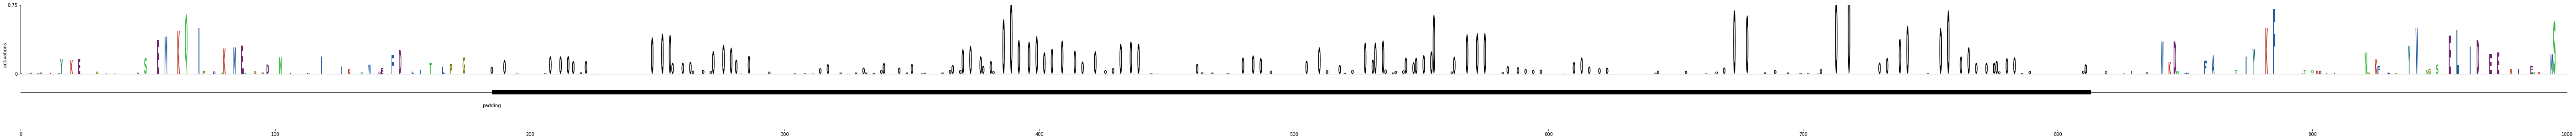

In [188]:
nn_logo = logomaker.Logo(pivoted_df, color_scheme='NajafabadiEtAl2017', figsize=(100, 5))
# style using Logo methods
nn_logo.style_spines(visible=False)
nn_logo.style_spines(spines=['left'], visible=True, bounds=[0, .75])

# style using Axes methods
nn_logo.ax.set_xlim([0, 1000])
nn_logo.ax.set_xticks([0,100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
nn_logo.ax.set_ylim([-.6, .75])
nn_logo.ax.set_yticks([0, .75])
nn_logo.ax.set_yticklabels(['0', '0.75'])
nn_logo.ax.set_ylabel('                 activations', labelpad=-1)

# draw gene
nn_logo.ax.axhline(y, color='k', linewidth=1)
#nn_logo.ax.plot(xs, ys, marker='4', linewidth=0, markersize=7, color='k')
nn_logo.ax.plot([first_zero, last_zero],
                [y, y], color='k', linewidth=10, solid_capstyle='butt')

# annotate gene
#nn_logo.ax.plot(first_zero, 1.8*y, '^k', markersize=15)
nn_logo.ax.text(first_zero, 1.6*y,'padding', verticalalignment='top', horizontalalignment='center')

In [44]:
folder = 'EC_number/archaea/3denses/bio_neurons/'

In [45]:
model_file = search_model(folder, str(fold), task, model_type)
model = load_model(model_file)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1000, 26)          0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1000, 26)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 26000)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 314)               8164314   
_________________________________________________________________
dropout_10 (Dropout)         (None, 314)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 77)                24255     
_________________________________________________________________
dropout_11 (Dropout)         (None, 77)                0         
__________

In [46]:
folder = 'EC_number/archaea/rnn_conv/256rnn/'

In [47]:
model_file = search_model(folder, str(fold), task, model_type)
model = load_model(model_file)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1000, 26)          0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 1000, 26)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1000, 64)          8384      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 100, 64)           0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 100, 64)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 512)               657408    
_________________________________________________________________
dense_9 (Dense)              (None, 314)               161082    
__________

In [48]:
folder = 'EC_number/archaea/stack_conv/10filts_sizeJurtz/'

In [49]:
model_file = search_model(folder, str(fold), task, model_type)
model = load_model(model_file)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1000, 26)     0                                            
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 1000, 26)     0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 1000, 10)     270         dropout_9[0][0]                  
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 1000, 10)     790         dropout_9[0][0]                  
__________________________________________________________________________________________________
conv1d_13 

In [ ]:
# Defining protein to take
idx = random_prot_idx(folder, "task1")
print(idx)
#Define list of dataframes
lista_dfs = []
for model_type in list_paddings:
    print("Model type: ", model_type)
    for fold in range(nfolds):
        model = search_model(folder, str(fold), task, model_type)
        prot, label = load_prot(folder, idx, model_type, "labels_task1", nshape)
        activations = obtain_activations(model, nlayer, prot)
        act_df = activations_to_df(activations, model_type, fold, label)
        lista_dfs.append(act_df)

findfont: Font family ['Arial Rounded MT Bold'] not found. Falling back to DejaVu Sans.


Running /home/angela/.local/lib/python3.6/site-packages/logomaker/examples/demo_fig1b.py:
-------------------------------------------------------------
# do imports
import matplotlib.pyplot as plt
import logomaker as logomaker

# load crp energy matrix
crp_df = -logomaker.get_example_matrix('crp_energy_matrix',
                                        print_description=False)

# create Logo object
crp_logo = logomaker.Logo(crp_df,
                          shade_below=.5,
                          fade_below=.5,
                          font_name='Arial Rounded MT Bold')

# style using Logo methods
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
crp_logo.style_xticks(rotation=90, fmt='%d', anchor=0)

# style using Axes methods
crp_logo.ax.set_ylabel("$-\Delta \Delta G$ (kcal/mol)", labelpad=-1)
crp_logo.ax.xaxis.set_ticks_position('none')
crp_logo.ax.xaxis.set_tick_params(pad=-1)

# style and show figure
crp_logo.fig.show()
----------

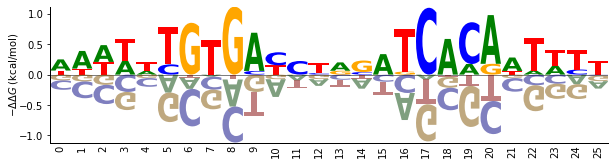

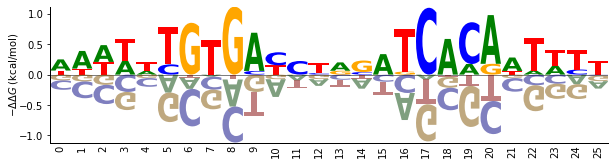

In [4]:
logomaker.demo('fig1b')

In [5]:
nn_df = logomaker.get_example_matrix('nn_saliency_matrix',
                                     print_description=False)

In [6]:
nn_df

,A,C,G,T
pos,,,,
0,-0.000000,-0.000000,-0.001725,-0.000000
1,0.000000,0.000000,0.033557,0.000000
2,0.000000,0.000000,0.030026,0.000000
3,0.000000,0.000000,0.012748,0.000000
4,0.000000,0.000000,0.000337,0.000000
5,0.000000,0.000000,0.010082,0.000000
6,0.007756,0.000000,0.000000,0.000000
7,-0.000000,-0.000504,-0.000000,-0.000000
8,0.000000,0.000000,0.000000,0.004781


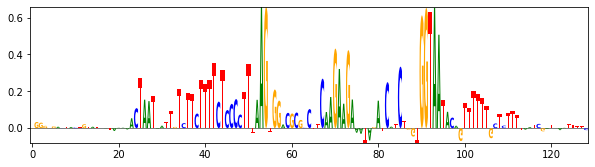

In [14]:
nn_logo = logomaker.Logo(nn_df)

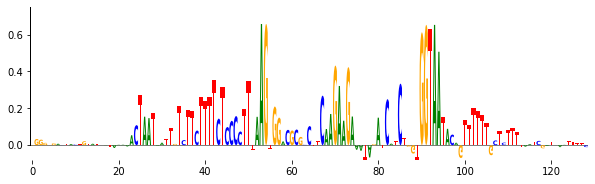

In [15]:
nn_logo = logomaker.Logo(nn_df)
# style using Logo methods
nn_logo.style_spines(visible=False)
nn_logo.style_spines(spines=['left'], visible=True, bounds=[0, .75])

Text(0, 0.5, '                 saliency')

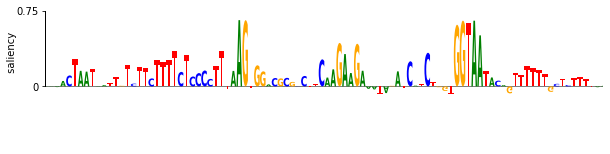

In [16]:
nn_logo = logomaker.Logo(nn_df)
# style using Logo methods
nn_logo.style_spines(visible=False)
nn_logo.style_spines(spines=['left'], visible=True, bounds=[0, .75])
# style using Axes methods
nn_logo.ax.set_xlim([20, 115])
nn_logo.ax.set_xticks([])
nn_logo.ax.set_ylim([-.6, .75])
nn_logo.ax.set_yticks([0, .75])
nn_logo.ax.set_yticklabels(['0', '0.75'])
nn_logo.ax.set_ylabel('                 saliency', labelpad=-1)

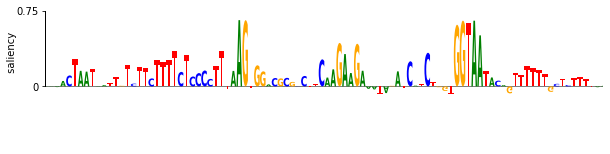

In [17]:
nn_logo = logomaker.Logo(nn_df)
# style using Logo methods
nn_logo.style_spines(visible=False)
nn_logo.style_spines(spines=['left'], visible=True, bounds=[0, .75])
# style using Axes methods
nn_logo.ax.set_xlim([20, 115])
nn_logo.ax.set_xticks([])
nn_logo.ax.set_ylim([-.6, .75])
nn_logo.ax.set_yticks([0, .75])
nn_logo.ax.set_yticklabels(['0', '0.75'])
nn_logo.ax.set_ylabel('                 saliency', labelpad=-1)
# set parameters for drawing gene
exon_start = 55-.5
exon_stop = 90+.5
y = -.2
xs = np.arange(-3, len(nn_df),10)
ys = y*np.ones(len(xs))

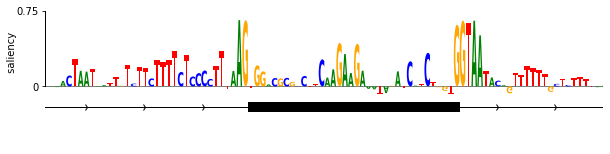

In [18]:
nn_logo = logomaker.Logo(nn_df)
# style using Logo methods
nn_logo.style_spines(visible=False)
nn_logo.style_spines(spines=['left'], visible=True, bounds=[0, .75])
# style using Axes methods
nn_logo.ax.set_xlim([20, 115])
nn_logo.ax.set_xticks([])
nn_logo.ax.set_ylim([-.6, .75])
nn_logo.ax.set_yticks([0, .75])
nn_logo.ax.set_yticklabels(['0', '0.75'])
nn_logo.ax.set_ylabel('                 saliency', labelpad=-1)
# set parameters for drawing gene
exon_start = 55-.5
exon_stop = 90+.5
y = -.2
xs = np.arange(-3, len(nn_df),10)
ys = y*np.ones(len(xs))
# draw gene
nn_logo.ax.axhline(y, color='k', linewidth=1)
nn_logo.ax.plot(xs, ys, marker='4', linewidth=0, markersize=7, color='k')
nn_logo.ax.plot([exon_start, exon_stop],
                [y, y], color='k', linewidth=10, solid_capstyle='butt')

Text(54.5, -0.5, 'chr3:142,740,192')

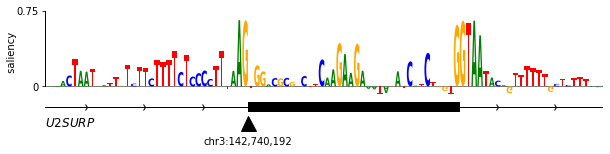

In [13]:
nn_logo = logomaker.Logo(nn_df)
# style using Logo methods
nn_logo.style_spines(visible=False)
nn_logo.style_spines(spines=['left'], visible=True, bounds=[0, .75])
# style using Axes methods
nn_logo.ax.set_xlim([20, 115])
nn_logo.ax.set_xticks([])
nn_logo.ax.set_ylim([-.6, .75])
nn_logo.ax.set_yticks([0, .75])
nn_logo.ax.set_yticklabels(['0', '0.75'])
nn_logo.ax.set_ylabel('                 saliency', labelpad=-1)
# set parameters for drawing gene
exon_start = 55-.5
exon_stop = 90+.5
y = -.2
xs = np.arange(-3, len(nn_df),10)
ys = y*np.ones(len(xs))
# draw gene
nn_logo.ax.axhline(y, color='k', linewidth=1)
nn_logo.ax.plot(xs, ys, marker='4', linewidth=0, markersize=7, color='k')
nn_logo.ax.plot([exon_start, exon_stop],
                [y, y], color='k', linewidth=10, solid_capstyle='butt')

# annotate gene
nn_logo.ax.plot(exon_start, 1.8*y, '^k', markersize=15)
nn_logo.ax.text(20,2*y,'$U2SURP$',fontsize=12)
nn_logo.ax.text(exon_start, 2.5*y,'chr3:142,740,192', verticalalignment='top', horizontalalignment='center')